In [249]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, UpSampling2D, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import tensorflow.keras
import os

In [250]:
"""
Because we are going to replace the encoder part with VGG16, 
we don’t need it as a classifier, we need it as a feature extractor so, 
the last dense layers isn’t needed we have to pop them up.
here, we iterate on each layer except the last dense layers so, 
we add 19 layer to our model. the dimension of last layer volume is “7x7x512”. 
we will be using that latent space volume as a feature vector to be input to the decoder.
 and the decoder is going to learn the mapping from the latent space vector to ab channels. 
 we want the layers of VGG16 with its original weights without changing them, 
 so that we set the trainable parameter in each layer to false because we don’t want to train them again.
"""

'\nBecause we are going to replace the encoder part with VGG16, \nwe don’t need it as a classifier, we need it as a feature extractor so, \nthe last dense layers isn’t needed we have to pop them up.\nhere, we iterate on each layer except the last dense layers so, \nwe add 19 layer to our model. the dimension of last layer volume is “7x7x512”. \nwe will be using that latent space volume as a feature vector to be input to the decoder.\n and the decoder is going to learn the mapping from the latent space vector to ab channels. \n we want the layers of VGG16 with its original weights without changing them, \n so that we set the trainable parameter in each layer to false because we don’t want to train them again.\n'

In [251]:
from tensorflow.keras.applications.vgg16 import VGG16
vggmodel = VGG16()
newmodel = Sequential() 
#num = 0
for i, layer in enumerate(vggmodel.layers):
    if i<19:          #Only up to 18th layer to include feature extraction only
      newmodel.add(layer)
newmodel.summary()
for layer in newmodel.layers:
  layer.trainable=False   #We don't want to train these layers again, so False. 


Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)     

In [252]:
"""
VGG16 is expecting an image of 3 dimension with size 224x224 as an input, 
in preprocessing we have to scale all images to 224 instead of 256
"""
path = 'archive/colorization'
#Normalize images - divide by 255
train_datagen = ImageDataGenerator(rescale=1. / 255)

train = train_datagen.flow_from_directory(path, target_size=(224, 224), batch_size=32, class_mode=None)

Found 424 images belonging to 4 classes.


In [253]:
#Convert from RGB to Lab
"""
by iterating on each image, we convert the RGB to Lab. 
Think of LAB image as a grey image in L channel and all color info stored in A and B channels. 
The input to the network will be the L channel, so we assign L channel to X vector. 
And assign A and B to Y.
"""

X =[]
Y =[]
for i in range(0,len(train)):
    for img in train[0]:
      try:
          lab = rgb2lab(img)
          X.append(lab[:,:,0]) 
          Y.append(lab[:,:,1:] / 128) #A and B values range from -127 to 128, 
          #so we divide the values by 128 to restrict values to between -1 and 1.
      except:
         print('error')
X = np.array(X)
Y = np.array(Y)
X = X.reshape(X.shape+(1,)) #dimensions to be the same for X and Y
print(X.shape)
print(Y.shape)

(448, 224, 224, 1)
(448, 224, 224, 2)


In [254]:
#now we have one channel of L in each layer but, VGG16 is expecting 3 dimension, 
#so we repeated the L channel two times to get 3 dimensions of the same L channel

vggfeatures = []
for i, sample in enumerate(X):
  sample = gray2rgb(sample)
  sample = sample.reshape((1,224,224,3))
  prediction = newmodel.predict(sample)
  prediction = prediction.reshape((7,7,512))
  vggfeatures.append(prediction)
vggfeatures = np.array(vggfeatures)
print(vggfeatures.shape)

(448, 7, 7, 512)


In [255]:
#Decoder
model = Sequential()

model.add(Conv2D(256, (3,3), activation='relu', padding='same', input_shape=(7,7,512)))
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_90 (Conv2D)           (None, 7, 7, 256)         1179904   
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 7, 7, 128)         295040    
_________________________________________________________________
up_sampling2d_75 (UpSampling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 14, 14, 64)        73792     
_________________________________________________________________
up_sampling2d_76 (UpSampling (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 28, 28, 32)        18464     
_________________________________________________________________
up_sampling2d_77 (UpSampling (None, 56, 56, 32)      

In [256]:
model.compile(optimizer='Adam', loss='mse' , metrics=['accuracy'])
model.fit(vggfeatures, Y, verbose=1, epochs=10, batch_size=6)

Train on 424 samples
Epoch 1/10
424/424 [==============================] - 154678s 149ms/sample - loss: 0.2321 - accuracy: 0.6251
Epoch 2/10
424/424 [==============================] - 134563s 120ms/sample - loss: 0.0256 - accuracy: 0.6333
Epoch 3/10
424/424 [==============================] - 154618s 135ms/sample - loss: 0.0222 - accuracy: 0.6746
Epoch 4/10
424/424 [==============================] - 183666s 142ms/sample - loss: 0.0214 - accuracy: 0.6933
Epoch 5/10
424/424 [==============================] - 132122s 118ms/sample - loss: 0.0109 - accuracy: 0.7401
Epoch 6/10
424/424 [==============================] - 167687s 141ms/sample - loss: 0.0108 - accuracy: 0.7814
Epoch 7/10
424/424 [==============================] - 154333s 133ms/sample - loss: 0.0107 - accuracy: 0.8473
Epoch 8/10
424/424 [==============================] - 194231s 155ms/sample - loss: 0.0096 - accuracy: 0.8475
Epoch 9/10
424/424 [==============================] - 155311s 131ms/sample - loss: 0.0116 - accuracy: 0.857

In [259]:
model.save('colorize_autoencoder_VGG16_4.model')

INFO:tensorflow:Assets written to: colorize_autoencoder_VGG16_4.model/assets


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


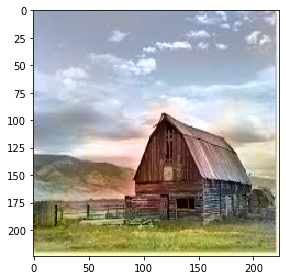

In [277]:
#Predicting using saved model.
from skimage.io import imread, imshow, imread_collection, concatenate_images
model = tf.keras.models.load_model('colorize_autoencoder_VGG16_4.model',custom_objects=None,compile=True)
test = img_to_array(load_img('archive/colorization2/test/sunset1.jpg'))
test = resize(test, (224,224), anti_aliasing=True)
test*= 1.0/255
lab = rgb2lab(test)
l = lab[:,:,0]
L = gray2rgb(l)
L = L.reshape((1,224,224,3))
    #print(L.shape)
vggpred = newmodel.predict(L)
ab = model.predict(vggpred)
    #print(ab.shape)
ab = ab*128
cur = np.zeros((224, 224, 3))
cur[:,:,0] = l
cur[:,:,1:] = ab
imshow(lab2rgb(cur))
imsave("result1.png", lab2rgb(cur))

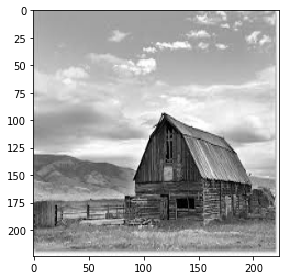

In [278]:
test = img_to_array(load_img('archive/colorization2/test/sunset1.jpg'))
test = resize(test, (224,224), anti_aliasing=True)
test= test*1/255
imshow(test)